In [1]:
import warnings
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline
from matplotlib import colormaps

In [2]:
def wrangle(filepath):
    df = pd.read_csv(filepath)

    # Remove high Cardiality features

    df = df.drop("patientid", axis=1)

    # Create relevant categories
    df["BP_category"] = pd.cut(df["restingBP"], bins=[80, 119, 129, 139, 179, 200], labels=["Normal", "Mild", "HP1", "HP2", "Critical"] )
    df["age_groups"] = pd.cut(df["age"], bins=[15, 35, 60, 80], labels=["Young", "Middle_aged",  "Old"] )

    # Map Variables
    df["BP_category"] = df["BP_category"].map({"Normal":0, "Mild":1, "HP1":2, "HP2":3, "Critical":4})
    df["age_groups"] = df["age_groups"].map({"Young":0, "Middle_aged":1, "Old":2})

    # Drop collinear features
    df = df.drop(["restingBP", "age"], axis=1)

    return df

In [3]:
df = wrangle("Cardiovascular_Disease_Dataset.csv")

### Data Split

In [4]:
data = df.iloc[:800]
test = df.iloc[801:]
data

,gender,chestpain,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target,BP_category,age_groups
0,1,2,0,0,1,147,0,5.3,3,3,1,3,1
1,1,0,229,0,1,115,0,3.7,1,1,0,0,1
2,1,2,142,0,0,202,1,5.0,1,0,0,2,1
3,1,0,295,1,1,153,0,3.2,2,2,1,2,1
4,1,1,0,0,2,136,0,5.3,3,2,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1,1,390,1,1,149,0,4.3,3,3,1,4,1
796,1,3,347,1,2,107,0,2.4,2,1,1,4,2
797,0,3,264,0,0,75,0,0.3,0,0,0,4,0
798,0,0,330,0,1,193,1,1.4,1,1,0,1,0


### Data Exploration

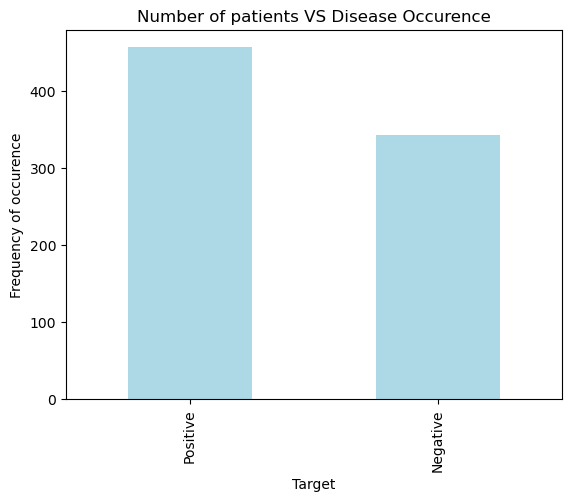

In [5]:
data["target"].value_counts().plot(kind="bar", color="lightblue")
plt.xlabel("Target")
plt.xticks([1,0],["Negative", "Positive"])
plt.ylabel("Frequency of occurence")
plt.title("Number of patients VS Disease Occurence");

The data shows no signs of being imbalanced in the direction of either class

In [6]:
nums = [i for i in data.columns if data[i].dtype == "int64"]
nums

['gender',
 'chestpain',
 'serumcholestrol',
 'fastingbloodsugar',
 'restingrelectro',
 'maxheartrate',
 'exerciseangia',
 'slope',
 'noofmajorvessels',
 'target']

In [7]:
data.columns

Index(['gender', 'chestpain', 'serumcholestrol', 'fastingbloodsugar',
       'restingrelectro', 'maxheartrate', 'exerciseangia', 'oldpeak', 'slope',
       'noofmajorvessels', 'target', 'BP_category', 'age_groups'],
      dtype='object')

In [8]:
matrix = data[nums].corr()

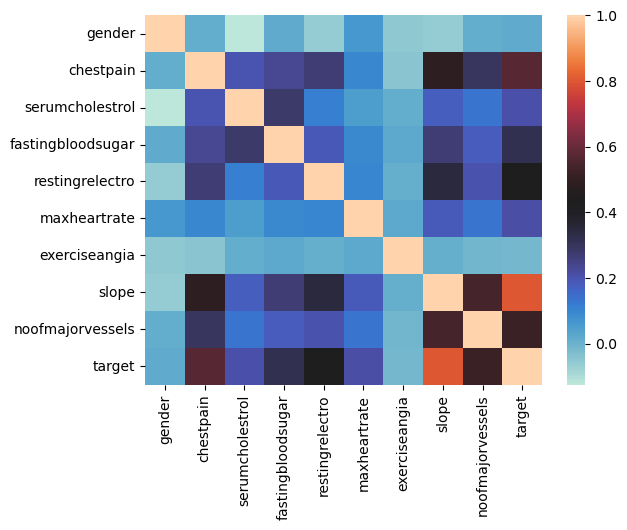

In [9]:
sns.heatmap(matrix, cmap="icefire");

No presence of multicollinearity amongst the features in the dataset, although slopeST is highly correlated with the target vector which indicates
it might be a strong predictor of CVD. Further investigation is required. 

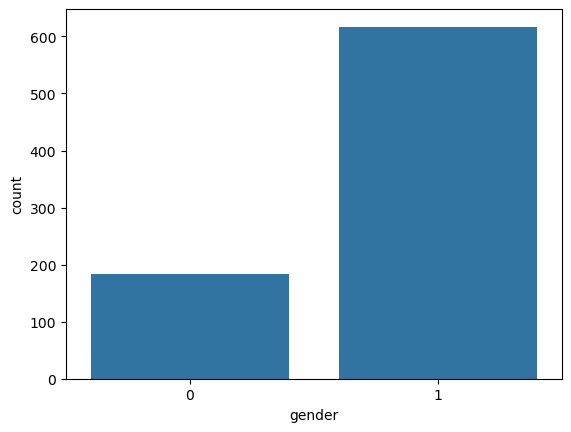

In [10]:
sns.countplot(data, x="gender");

Disproportionately more men than women are recorded in the dataset

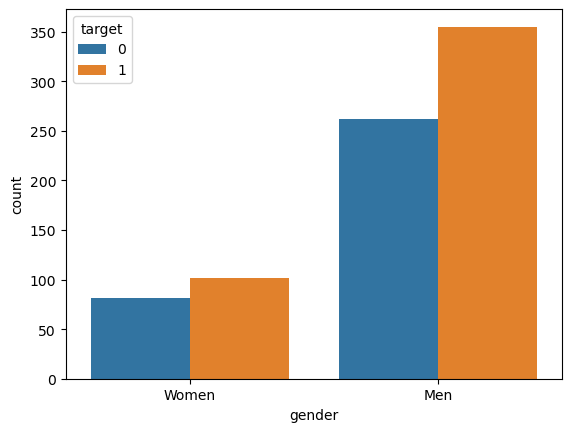

In [11]:
# Frequency of disease occurence by gender
sns.countplot(data,
           x="gender",
           hue="target");
plt.xticks([0, 1], ["Women", "Men"]);

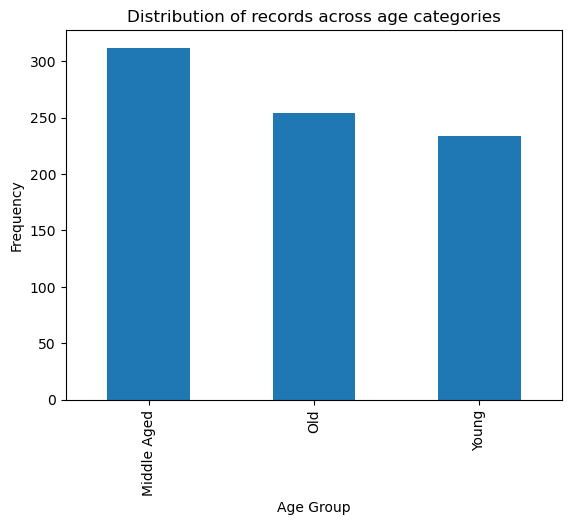

In [12]:
data["age_groups"].value_counts().plot(kind="bar");
plt.xlabel("Age Group")
plt.ylabel("Frequency")
plt.title("Distribution of records across age categories")
plt.xticks([0, 1, 2],["Middle Aged", "Old", "Young"]);

In [13]:
i = data["age_groups"].value_counts()/len(data)

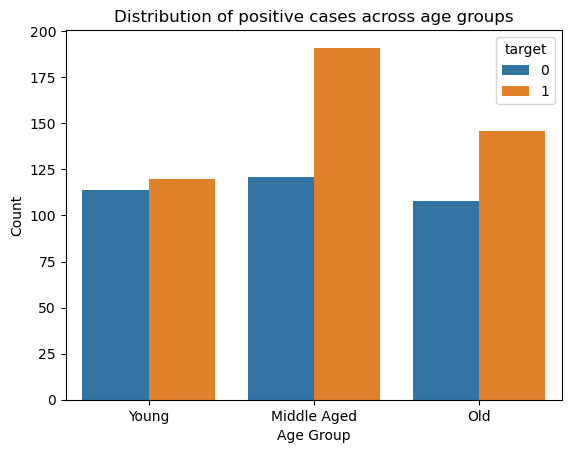

In [14]:
sns.countplot(
    data,
    x="age_groups",
    hue="target"
);
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.title("Distribution of positive cases across age groups")
plt.xticks([0, 1, 2],["Young", "Middle Aged", "Old"]);

This indicates that the majority of our positive cases being recorded occur in people middle aged or older, with negative cases remaining relatively stable across age groups

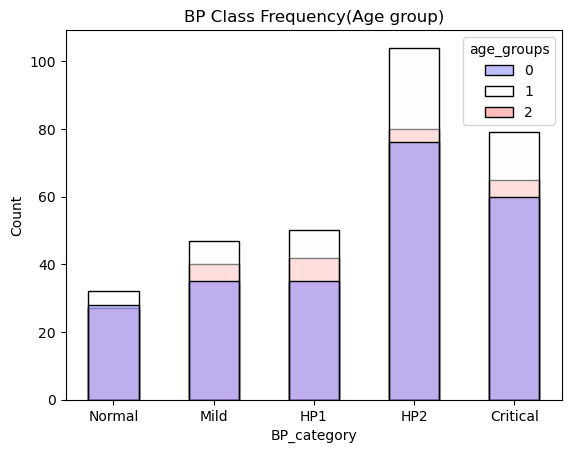

In [15]:
sns.histplot(data,
             x="BP_category",
             hue="age_groups",
             multiple="layer",
             stat = "count",
             shrink=.5,
             palette = "bwr"
            );

plt.title("BP Class Frequency(Age group)");
plt.xticks([0,1,2,3,4], ["Normal", "Mild", "HP1", "HP2", "Critical"]);


Middle and (to a lesser extent) old aged individuals are dispropotionately represented in the Hypertensive and Critical Categories.

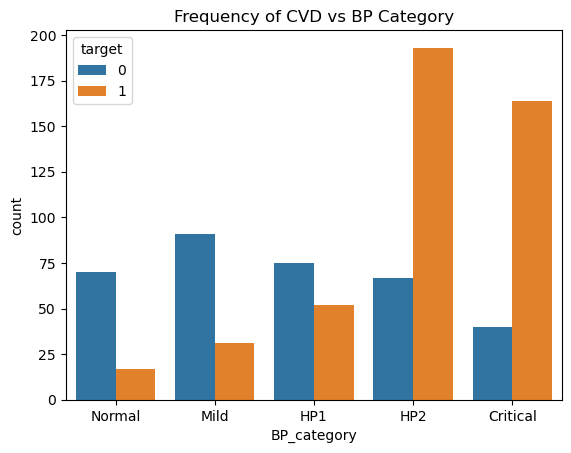

In [16]:
sns.countplot(
    data,
    x="BP_category",
    hue="target"
)
plt.title("Frequency of CVD vs BP Category")
plt.xticks([0,1,2,3,4], ["Normal", "Mild", "HP1", "HP2", "Critical"]);


The diagrams above simply reinforce an intuitive assumption; The chances of Hypertension and CVD increase with age, with progressively higher Blood Pressure levels showing strong links to CVD

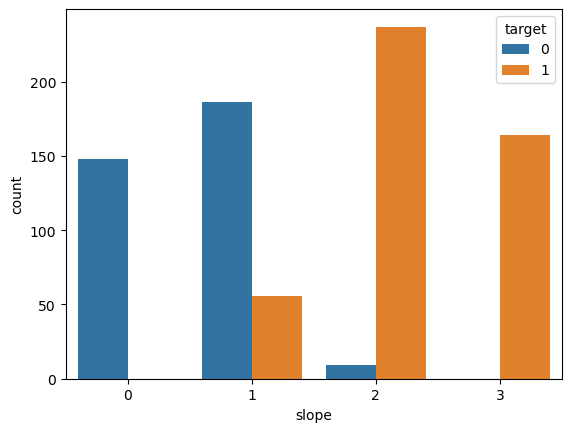

In [17]:
sns.countplot(data,
              x="slope",
              hue="target",);

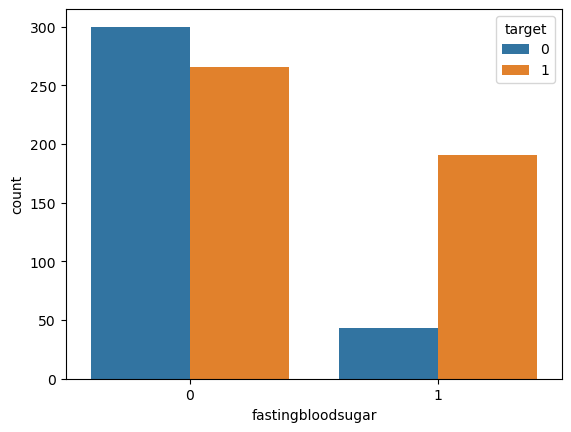

In [18]:
data["fastingbloodsugar"].value_counts()
sns.countplot(
    data,
    x="fastingbloodsugar",
    hue="target"
);

Basline Accuracy Score = 57%

## Model Building

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split


In [20]:
X = data.drop("target", axis=1)
y = data["target"]

In [21]:
test_feats = test.drop("target", axis=1)
test_tag = test["target"]

### Logistic Regression

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [23]:
param_grid = [
    {"penalty":["l1", "l2"],"C":[0.1, 0.2, 0.3]}
]

In [24]:
val = GridSearchCV(LogisticRegression(random_state=42), param_grid, n_jobs=-1)

In [25]:
pred = val.fit(X_test, y_test)

In [26]:
pred.best_params_

{'C': 0.2, 'penalty': 'l2'}

In [27]:
model =  make_pipeline(LogisticRegression(random_state=42, C=0.2, penalty="l2"))

In [28]:
model.fit(X_train, y_train)

Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=0.2, random_state=42))])

In [29]:
accuracy_score(model.predict(X_train), y_train)

0.9569444444444445

In [30]:
model.score(X_test, y_test)

0.9

In [31]:
test_feats = test.drop("target", axis=1)
test_tag = test["target"]

In [32]:
model.score(test_feats, test_tag)

0.9346733668341709

### Decision Tree Classifer

In [33]:
depth = list(range(1, 8))

In [34]:
score = []
for d in depth:
    model =  make_pipeline(DecisionTreeClassifier(random_state=42, max_depth = d))
    model.fit(X_train, y_train)
    score.append({f"max_depth {d}":model.score(X_train, y_train)})
print(score)

[{'max_depth 1': 0.9180555555555555}, {'max_depth 2': 0.9361111111111111}, {'max_depth 3': 0.9472222222222222}, {'max_depth 4': 0.9597222222222223}, {'max_depth 5': 0.9625}, {'max_depth 6': 0.9736111111111111}, {'max_depth 7': 0.9833333333333333}]


In [35]:
model =  make_pipeline(DecisionTreeClassifier(random_state=42, max_depth = 7))

In [36]:
model.fit(X_train, y_train)

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=7, random_state=42))])

In [37]:
model.score(X_test, y_test)

0.9375

In [38]:
model.score(test_feats, test_tag)

0.9447236180904522

### Random Forest Classifier

In [39]:
score = []
for d in depth:
    model =  make_pipeline(RandomForestClassifier(random_state=42, max_depth = d))
    model.fit(X_train, y_train)
    score.append({f"max_depth {d}":model.score(X_train, y_train)})
print(score)

[{'max_depth 1': 0.925}, {'max_depth 2': 0.9458333333333333}, {'max_depth 3': 0.9652777777777778}, {'max_depth 4': 0.9736111111111111}, {'max_depth 5': 0.9805555555555555}, {'max_depth 6': 0.9875}, {'max_depth 7': 0.9944444444444445}]


In [40]:
model =  make_pipeline(RandomForestClassifier(random_state=42, max_depth = 7))

In [41]:
model.fit(X_train, y_train)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=7, random_state=42))])

In [42]:
model.score(X_test, y_test)

0.9625

In [43]:
model.score(test_feats, test_tag)

0.9547738693467337

In [44]:
info  = pd.Series(model.named_steps["randomforestclassifier"].feature_importances_, index=test_feats.columns)

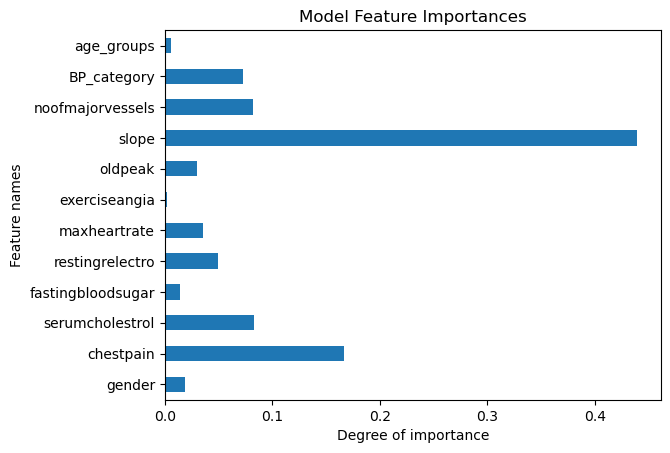

In [45]:
info.plot(kind="barh");
plt.xlabel("Degree of importance")
plt.ylabel("Feature names")
plt.title("Model Feature Importances");

In [46]:
precision_score(model.predict(test_feats), test_tag)

0.9344262295081968